# Time Series & Feature Exploration Notebook

This notebook provides a comprehensive toolkit for exploring, visualizing, and diagnosing time series and features in the respiratory morbidity dataset. You can select a specific city (by IBGE code) or analyze the sum across all cities (countrywise).

In [4]:
import sys
import os

# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(f"Project root: {project_root}")

# Add the project root to sys.path (not the src directory)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to sys.path")
# Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from scipy.stats import boxcox, zscore, skew, kurtosis, entropy
from pandas.tseries.frequencies import to_offset
from dateutil import parser
import warnings
warnings.filterwarnings('ignore')

# For interactive widgets (city selection, etc.)
try:
    from ipywidgets import interact, widgets
except ImportError:
    interact = None
    widgets = None

Project root: c:\Users\pedro\OneDrive - Unesp\Documentos\GitHub\cities-models\cities-models


## 1. Data Loading & City Selection
- Load the main dataset.
- Allow user to select a city (by IBGE code) or "All" for countrywise sum.

In [ ]:
# Load data
DATA_PATH = '../data/df_base_morb_resp.csv'
df = pd.read_csv(DATA_PATH) # Load without parsing dates first

# Convert week column to datetime safely with error handling
try:
    df['week'] = pd.to_datetime('1999-01-01') + pd.to_timedelta(df['week'] - 1, unit='W')
    if df['week'].isna().any():
        print(f"Warning: {df['week'].isna().sum()} entries in 'week' column couldn't be parsed to datetime")
        print("Sample of problematic entries:", df.loc[df['week'].isna(), 'week'].head().to_list())
except Exception as e:
    print(f"Error converting 'week' column to datetime: {e}")
    print("Proceeding with original 'week' column")

# List of available cities
city_codes = df['CD_MUN'].unique()
city_options = ['All'] + sorted(city_codes.tolist())

# Widget for city selection (if available)
def select_city(city_code='All'):
    if city_code == 'All':
        df_sel = df.groupby('week').agg({col: 'sum' if df[col].dtype != 'O' else 'first' for col in df.columns if col != 'week'}).reset_index()
        label = 'All Cities (Sum)'
    else:
        df_sel = df[df['CD_MUN'] == int(city_code)].copy()
        label = f'City {city_code}'
    return df_sel, label

if interact:
    city_widget = widgets.Dropdown(options=city_options, value='All', description='City:')
    display(city_widget)
    city_code = city_widget.value
else:
    city_code = 'All'
df_city, city_label = select_city(city_code)
print(f"Selected: {city_label}, shape: {df_city.shape}")

Selected: All Cities (Sum), shape: (1200, 11)


## 2. Basic Structure & Summary
- Missing values, duplicates, gaps, summary stats, raw plot, resampling.

Missing values (count):
 week      0
CD_MUN    0
target    0
PIB       0
DENS      0
URB       0
CO2       0
CH4       0
N2O       0
LAT       0
LON       0
dtype: int64
Missing values (%):
 week      0.0
CD_MUN    0.0
target    0.0
PIB       0.0
DENS      0.0
URB       0.0
CO2       0.0
CH4       0.0
N2O       0.0
LAT       0.0
LON       0.0
dtype: float64
Duplicate timestamps: 0
Number of missing weeks: 0

DataFrame summary:
                                week        CD_MUN       target           PIB  \
count                           1200  1.200000e+03  1200.000000  1.200000e+03   
mean   1970-01-01 00:00:00.000000599  1.812250e+10  2623.875833  6.990939e+07   
min              1970-01-01 00:00:00  1.812250e+10  1428.463066  0.000000e+00   
25%    1970-01-01 00:00:00.000000299  1.812250e+10  2074.620349  3.441968e+07   
50%    1970-01-01 00:00:00.000000599  1.812250e+10  2567.214171  6.184042e+07   
75%    1970-01-01 00:00:00.000000899  1.812250e+10  3050.766786  1.037256e+08   
ma

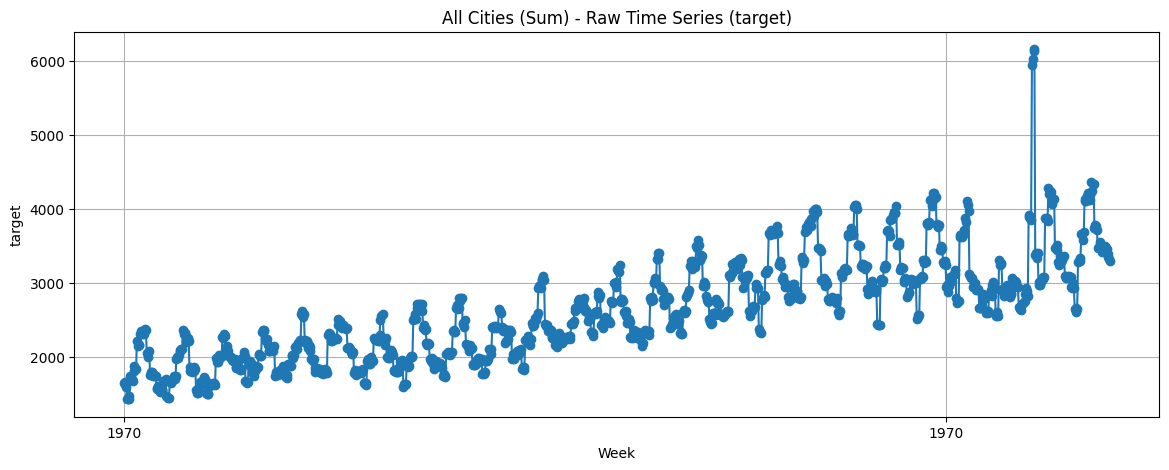

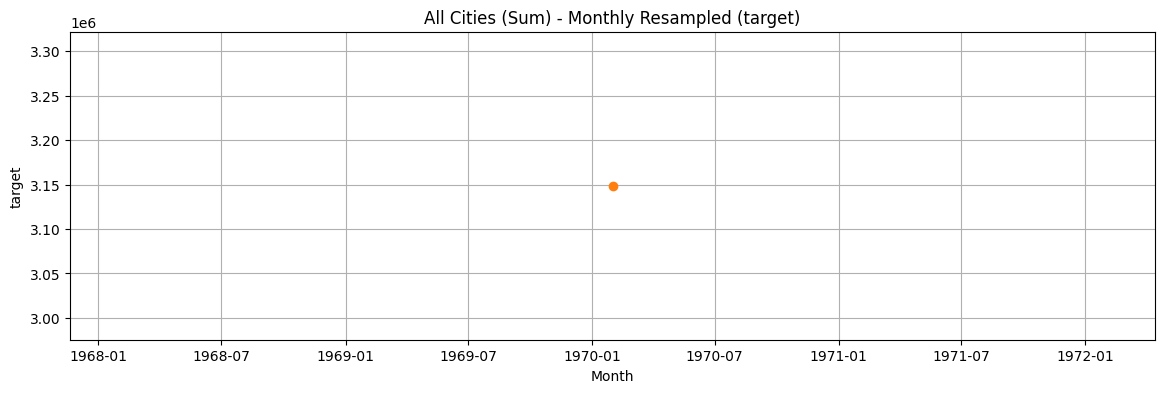

In [6]:
# Missing values
missing = df_city.isnull().sum()
missing_pct = df_city.isnull().mean() * 100
print('Missing values (count):\n', missing)
print('Missing values (%):\n', missing_pct)

# Duplicates
duplicates = df_city.duplicated(subset=['week']).sum()
print(f"Duplicate timestamps: {duplicates}")

# Gaps in time - Robust way
df_city = df_city.sort_values('week') if 'week' in df_city.columns else df_city

# Only proceed with gap analysis if week is datetime
if 'week' in df_city.columns and pd.api.types.is_datetime64_dtype(df_city['week']):
    # Clean df_city by removing NaT values in 'week'
    df_city_cleaned = df_city.dropna(subset=['week'])
    
    if not df_city_cleaned.empty:
        min_week = df_city_cleaned['week'].min()
        max_week = df_city_cleaned['week'].max()
        
        if pd.notna(min_week) and pd.notna(max_week):
            try:
                # Create date range with appropriate frequency
                all_weeks = pd.date_range(start=min_week, end=max_week, freq='W')
                gaps = set(all_weeks) - set(df_city_cleaned['week'])
                print(f"Number of missing weeks: {len(gaps)}")
                if len(gaps) > 0 and len(gaps) < 10:  # Only show if manageable
                    print(f"Missing weeks (showing up to 10): {sorted(list(gaps))[:10]}")
            except Exception as e:
                print(f"Error computing gaps: {e}")
                print(f"Min week: {min_week}, Max week: {max_week}")
        else:
            print("Could not determine min/max dates for gap analysis")
    else:
        print("No valid datetime entries in 'week' column for gap analysis")
else:
    print("Gap analysis skipped: 'week' column not found or not datetime type")

# Summary statistics
print("\nDataFrame summary:")
try:
    print(df_city.describe(include='all'))
except Exception as e:
    print(f"Error generating summary statistics: {e}")

# Raw time series plot
target_col = 'target' if 'target' in df_city.columns else df_city.columns[-1]
print(f"\nUsing column '{target_col}' as target")

# Check if target column exists and is numeric
if target_col in df_city.columns and pd.api.types.is_numeric_dtype(df_city[target_col]):
    if 'week' in df_city.columns and pd.api.types.is_datetime64_dtype(df_city['week']):
        # Create clean subset for plotting
        df_plot = df_city.dropna(subset=['week', target_col])
        
        if not df_plot.empty:
            plt.figure(figsize=(14,5))
            plt.plot(df_plot['week'], df_plot[target_col], marker='o')
            plt.title(f"{city_label} - Raw Time Series ({target_col})")
            plt.xlabel('Week')
            plt.ylabel(target_col)
            plt.grid(True)
            plt.show()
            
            # Resample to monthly only if week is datetime
            try:
                df_month = df_plot.set_index('week')[target_col].resample('M').sum()
                plt.figure(figsize=(14,4))
                plt.plot(df_month.index, df_month.values, marker='o', color='tab:orange')
                plt.title(f"{city_label} - Monthly Resampled ({target_col})")
                plt.xlabel('Month')
                plt.ylabel(target_col)
                plt.grid(True)
                plt.show()
            except Exception as e:
                print(f"Error resampling to monthly: {e}")
        else:
            print("No valid data points for plotting after removing NaNs")
    else:
        print("Cannot create time series plot: 'week' column is missing or not datetime type")
        
        # Alternative: Plot using index if week is not datetime
        try:
            plt.figure(figsize=(14,5))
            plt.plot(df_city[target_col].values, marker='o')
            plt.title(f"{city_label} - Raw Series by Index ({target_col})")
            plt.xlabel('Index')
            plt.ylabel(target_col)
            plt.grid(True)
            plt.show()
        except Exception as e:
            print(f"Error creating alternative plot: {e}")
else:
    print(f"Cannot create plots: target column '{target_col}' not found or not numeric")

## 3. Stationarity & Trend Analysis
- STL decomposition, rolling stats, ADF/KPSS, differencing.

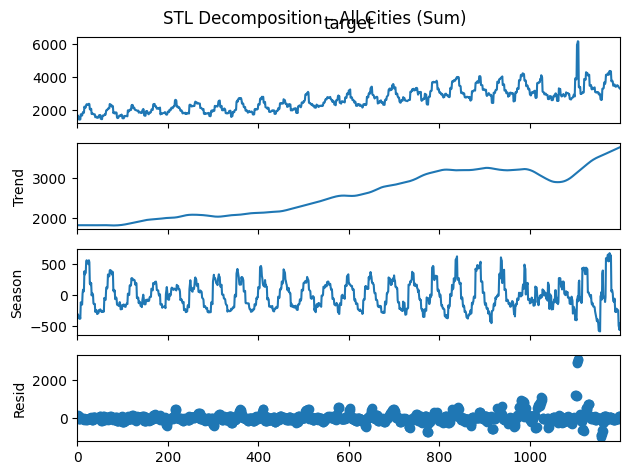

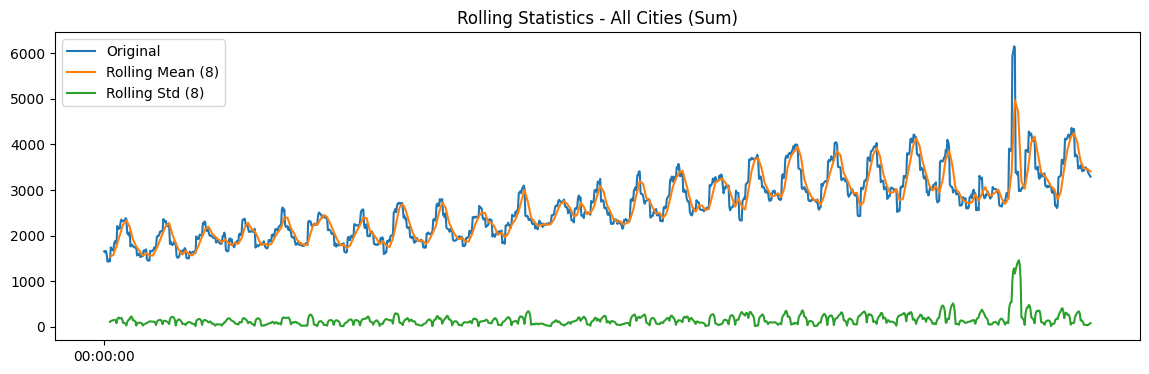

ADF Statistic: -3.055888584102571
p-value: 0.029994578592845014
KPSS Statistic: 4.901137662638969
p-value: 0.01


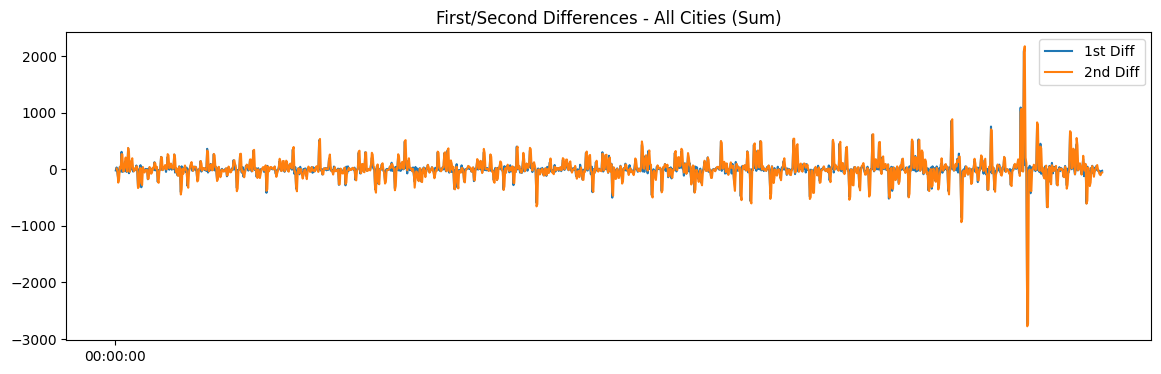

In [7]:
# STL decomposition
stl = STL(df_city[target_col], period=52, robust=True)
res = stl.fit()
res.plot()
plt.suptitle(f"STL Decomposition - {city_label}")
plt.show()

# Rolling mean & std
window = 8
plt.figure(figsize=(14,4))
plt.plot(df_city['week'], df_city[target_col], label='Original')
plt.plot(df_city['week'], df_city[target_col].rolling(window).mean(), label=f'Rolling Mean ({window})')
plt.plot(df_city['week'], df_city[target_col].rolling(window).std(), label=f'Rolling Std ({window})')
plt.legend()
plt.title(f"Rolling Statistics - {city_label}")
plt.show()

# Dickey-Fuller test
adf_result = adfuller(df_city[target_col].dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# KPSS test
try:
    kpss_result = kpss(df_city[target_col].dropna(), regression='c')
    print('KPSS Statistic:', kpss_result[0])
    print('p-value:', kpss_result[1])
except Exception as e:
    print('KPSS test failed:', e)

# First/second differences
plt.figure(figsize=(14,4))
plt.plot(df_city['week'], df_city[target_col].diff(), label='1st Diff')
plt.plot(df_city['week'], df_city[target_col].diff(2), label='2nd Diff')
plt.legend()
plt.title(f"First/Second Differences - {city_label}")
plt.show()

## 4. Seasonality & Cyclic Patterns
- Seasonal plots, ACF/PACF, periodogram, STL/Fourier, heatmaps.

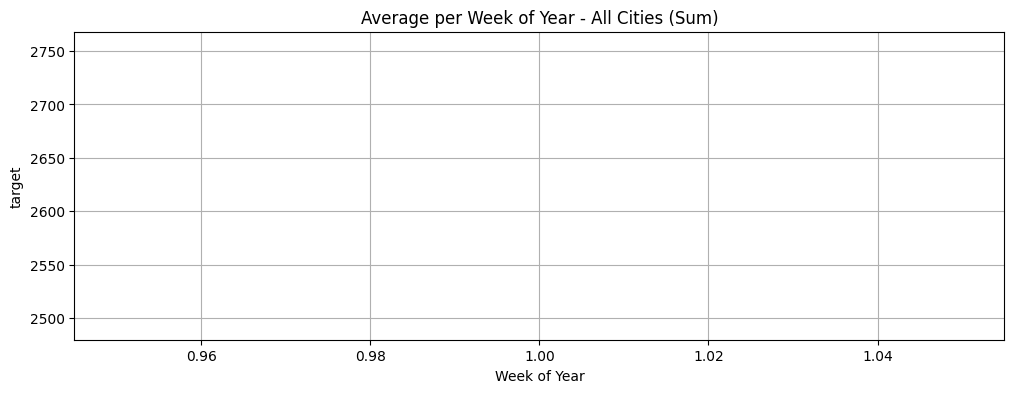

TypeError: Axes.stem() got an unexpected keyword argument 'use_line_collection'

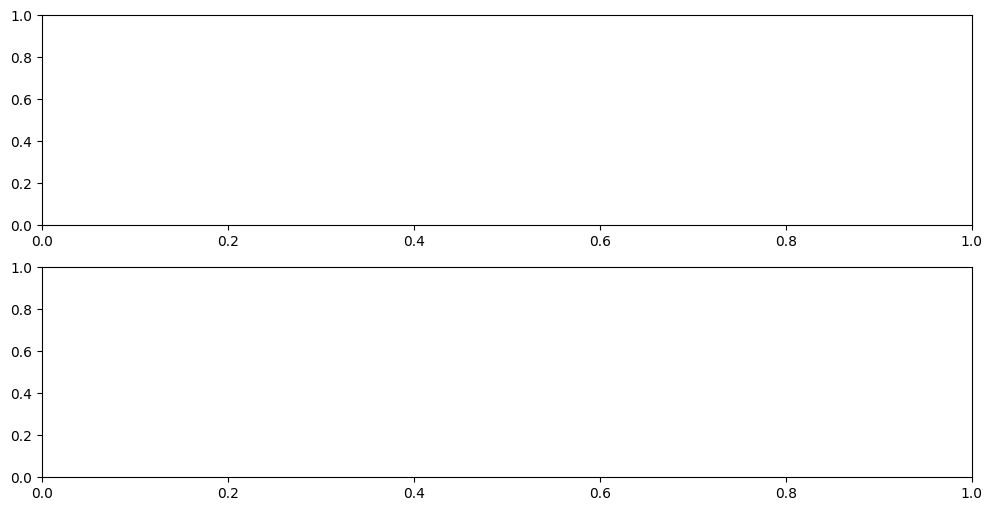

In [ ]:
# Seasonal plot: average per week of year
if 'week' in df_city.columns:
    df_city['weekofyear'] = df_city['week'].dt.isocalendar().week
    weekly_avg = df_city.groupby('weekofyear')[target_col].mean()
    plt.figure(figsize=(12,4))
    plt.plot(weekly_avg.index, weekly_avg.values)
    plt.title(f"Average per Week of Year - {city_label}")
    plt.xlabel('Week of Year')
    plt.ylabel(target_col)
    plt.grid(True)
    plt.show()

# ACF/PACF
lags = min(52, len(df_city)-1)
fig, ax = plt.subplots(2,1,figsize=(12,6))
acf_vals = acf(df_city[target_col].dropna(), nlags=lags)
pacf_vals = pacf(df_city[target_col].dropna(), nlags=lags)
ax[0].stem(range(len(acf_vals)), acf_vals)
ax[0].set_title('ACF')
ax[1].stem(range(len(pacf_vals)), pacf_vals)
ax[1].set_title('PACF')
plt.tight_layout()
plt.show()

# Periodogram
from scipy.signal import periodogram
freqs, power = periodogram(df_city[target_col].dropna())
plt.figure(figsize=(12,4))
plt.plot(freqs, power)
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.show()

# Heatmap: year vs week
if 'week' in df_city.columns:
    df_city['year'] = df_city['week'].dt.year
    df_city['weekofyear'] = df_city['week'].dt.isocalendar().week
    pivot = df_city.pivot_table(index='year', columns='weekofyear', values=target_col, aggfunc='mean')
    plt.figure(figsize=(16,6))
    sns.heatmap(pivot, cmap='coolwarm', annot=False)
    plt.title('Heatmap: Value by Year/Week')
    plt.show()

## 5. Outlier & Anomaly Detection
- Boxplots, z-score, visual spikes.

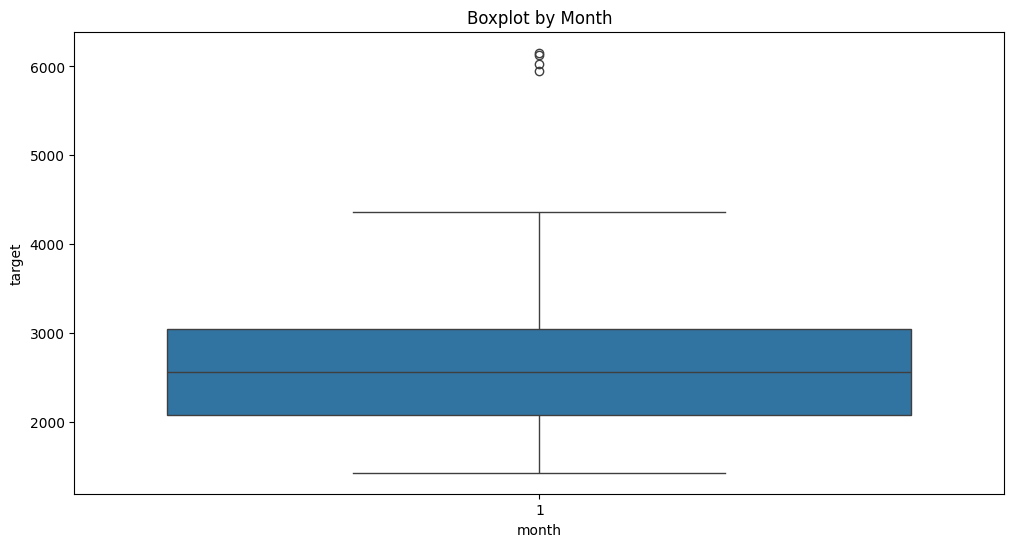

Number of z-score outliers (>3 std): 4


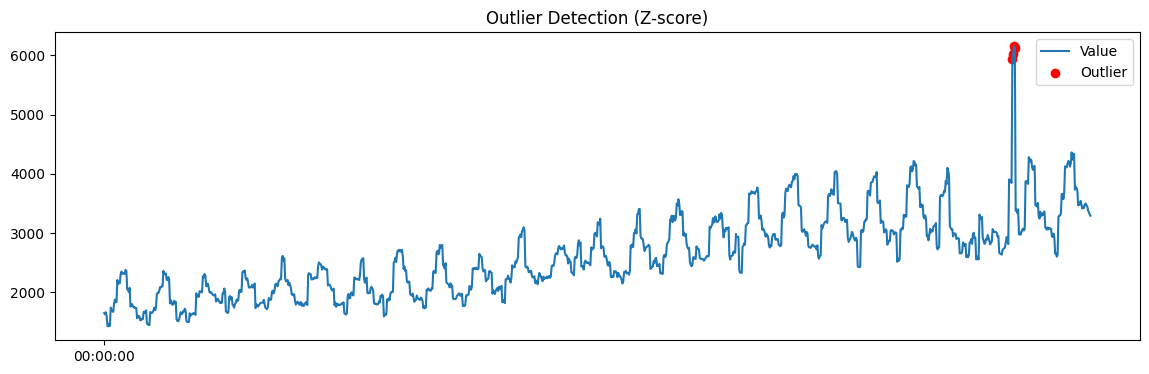

In [9]:
# Boxplot by month
if 'week' in df_city.columns:
    df_city['month'] = df_city['week'].dt.month
    plt.figure(figsize=(12,6))
    sns.boxplot(x='month', y=target_col, data=df_city)
    plt.title('Boxplot by Month')
    plt.show()

# Z-score outlier detection
zs = zscore(df_city[target_col].dropna())
outliers = np.where(np.abs(zs) > 3)[0]
print(f"Number of z-score outliers (>3 std): {len(outliers)}")
plt.figure(figsize=(14,4))
plt.plot(df_city['week'], df_city[target_col], label='Value')
plt.scatter(df_city['week'].iloc[outliers], df_city[target_col].iloc[outliers], color='red', label='Outlier')
plt.legend()
plt.title('Outlier Detection (Z-score)')
plt.show()

## 6. Distribution & Transformation
- Histogram, KDE, log/Box-Cox, skewness, kurtosis.

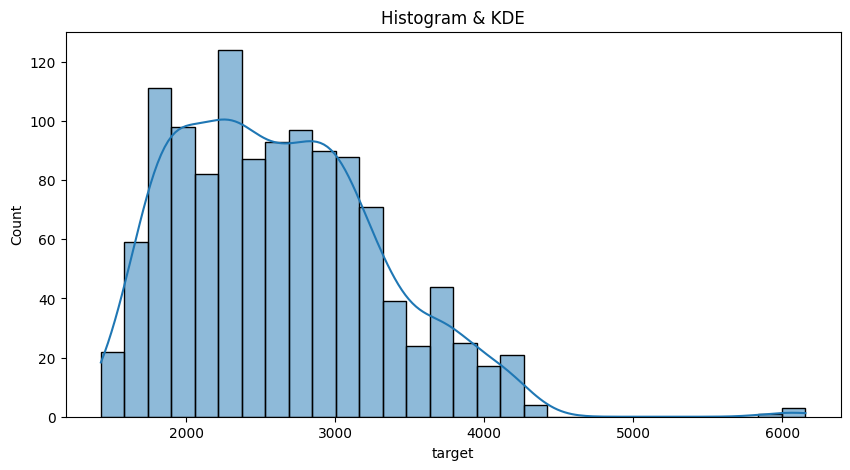

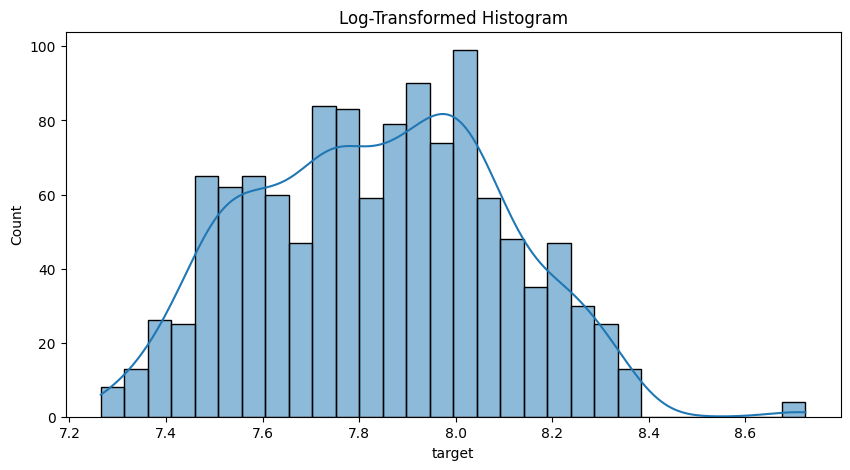

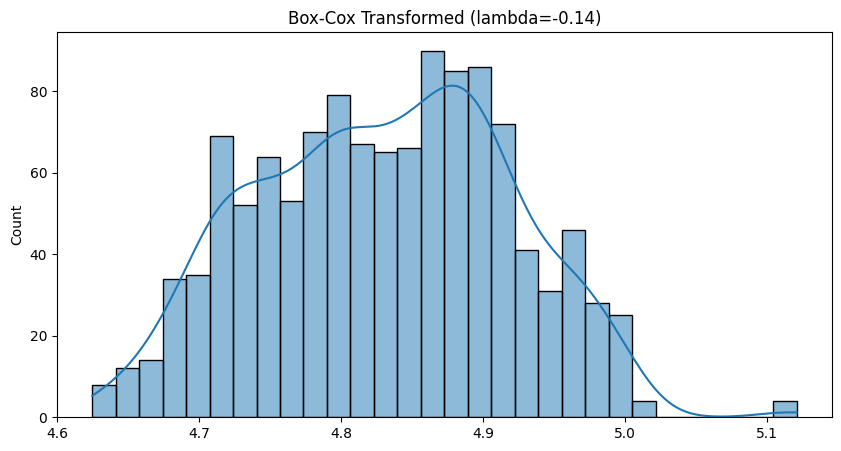

Skewness: 0.7619900381408836
Kurtosis: 1.1939980074521266


In [10]:
# Histogram & KDE
plt.figure(figsize=(10,5))
sns.histplot(df_city[target_col].dropna(), kde=True, bins=30)
plt.title('Histogram & KDE')
plt.show()

# Log transform
plt.figure(figsize=(10,5))
log_vals = np.log1p(df_city[target_col].dropna())
sns.histplot(log_vals, kde=True, bins=30)
plt.title('Log-Transformed Histogram')
plt.show()

# Box-Cox (only positive values)
if (df_city[target_col] > 0).all():
    bc_vals, bc_lambda = boxcox(df_city[target_col].dropna())
    plt.figure(figsize=(10,5))
    sns.histplot(bc_vals, kde=True, bins=30)
    plt.title(f'Box-Cox Transformed (lambda={bc_lambda:.2f})')
    plt.show()

# Skewness & kurtosis
print('Skewness:', skew(df_city[target_col].dropna()))
print('Kurtosis:', kurtosis(df_city[target_col].dropna()))

## 7. Feature Engineering Insights
- Lag correlation, exogenous features, date features, value by category.

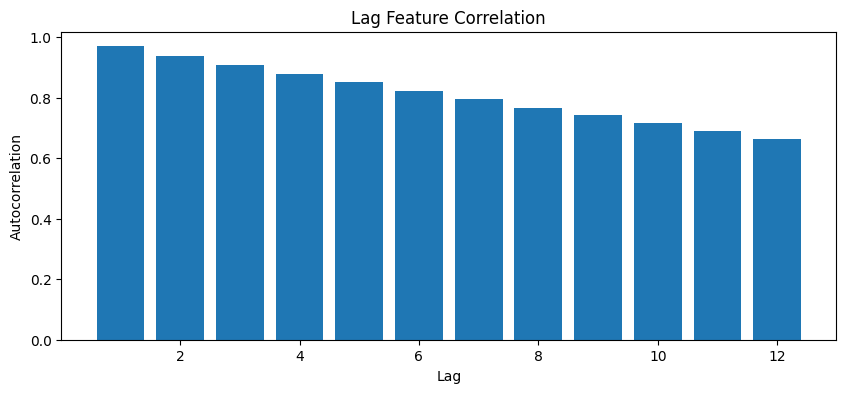

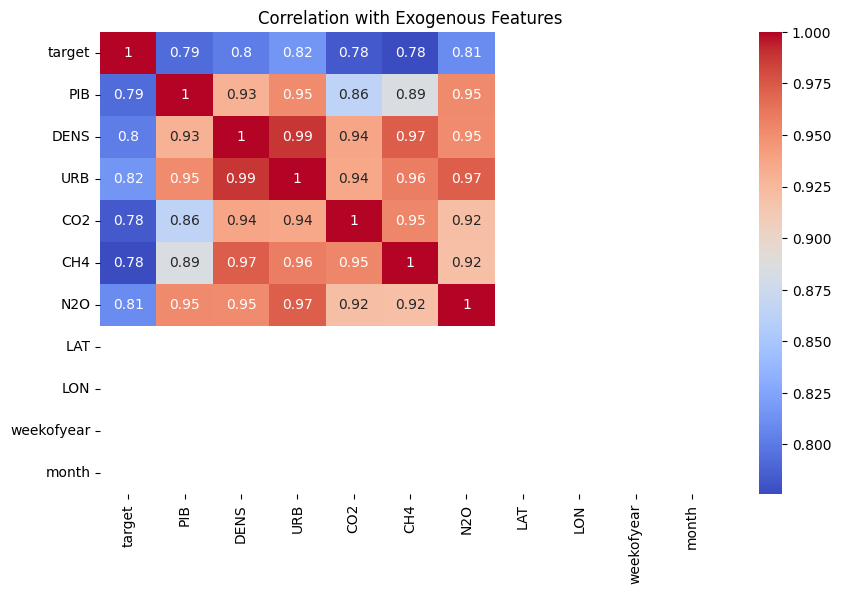

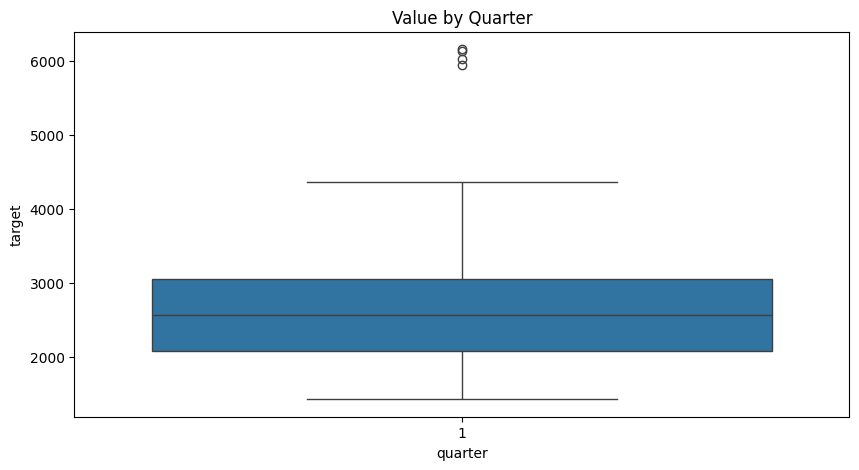

In [ ]:
# Lag feature correlation
max_lag = 12
corrs = [df_city[target_col].autocorr(lag) for lag in range(1, max_lag+1)]
plt.figure(figsize=(10,4))
plt.bar(range(1, max_lag+1), corrs)
plt.title('Lag Feature Correlation')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Correlation with exogenous features (if present)
exog_cols = [col for col in df_city.columns if col not in ['week', 'CD_MUN', target_col, 'lat', 'lon', 'weekofyear', 'month']]
if exog_cols:
    corr_matrix = df_city[[target_col] + exog_cols].corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation with Exogenous Features')
    plt.show()

# Date-based features
if 'week' in df_city.columns:
    df_city['weekofyear'] = df_city['week'].dt.isocalendar().week
    df_city['month'] = df_city['week'].dt.month
    df_city['quarter'] = df_city['week'].dt.quarter
    df_city['year'] = df_city['week'].dt.year
    # Value by season
    plt.figure(figsize=(10,5))
    sns.boxplot(x='quarter', y=target_col, data=df_city)
    plt.title('Value by Quarter')
    plt.show()

## 8. Forecastability & Complexity
- CV, entropy, naive baseline.

In [12]:
# Coefficient of Variation
cv = df_city[target_col].std() / df_city[target_col].mean()
print(f"Coefficient of Variation (CV): {cv:.3f}")

# Entropy (discretized)
vals = pd.cut(df_city[target_col].dropna(), bins=20, labels=False)
ent = entropy(np.bincount(vals))
print(f"Entropy (discretized): {ent:.3f}")

# Naive baseline (last value)
y_true = df_city[target_col].values[1:]
y_pred = df_city[target_col].values[:-1]
mae = np.mean(np.abs(y_true - y_pred))
print(f"Naive Last Value MAE: {mae:.2f}")

Coefficient of Variation (CV): 0.261
Entropy (discretized): 2.377
Naive Last Value MAE: 77.03


## 9. Domain-Specific Checks
- Health policy events, cumulative/incidence, reporting gaps.

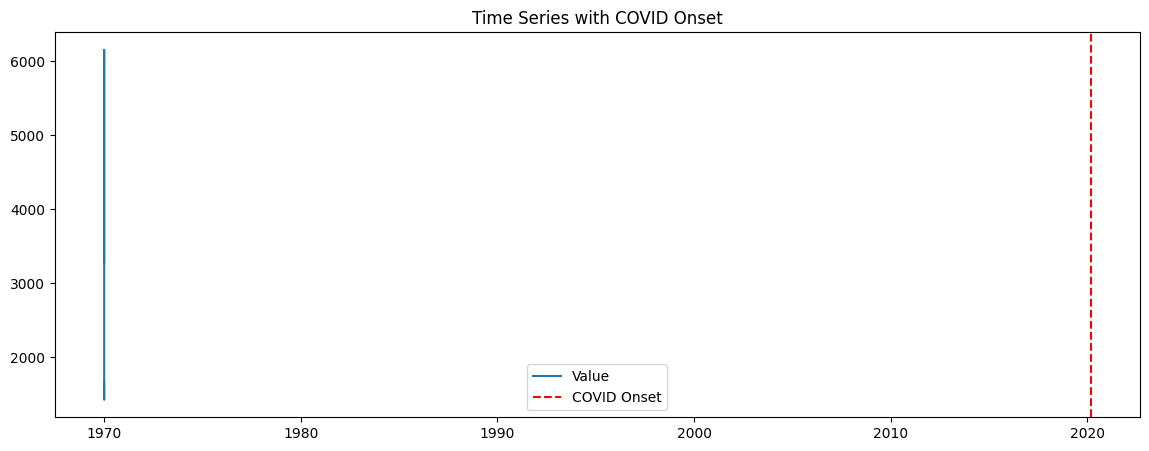

Target is not cumulative
No long reporting gaps detected


In [13]:
# Example: COVID onset vertical line
covid_start = pd.to_datetime('2020-03-01')
plt.figure(figsize=(14,5))
plt.plot(df_city['week'], df_city[target_col], label='Value')
plt.axvline(covid_start, color='red', linestyle='--', label='COVID Onset')
plt.title('Time Series with COVID Onset')
plt.legend()
plt.show()

# Check if target is cumulative (monotonic)
if (df_city[target_col].diff().dropna() >= 0).all():
    print('Target appears cumulative (monotonic increase)')
else:
    print('Target is not cumulative')

# Reporting delays: check for long gaps
week_diffs = df_city['week'].sort_values().diff().dt.days.dropna()
long_gaps = week_diffs[week_diffs > 14]
if not long_gaps.empty:
    print(f"Long reporting gaps (>{14} days):\n", long_gaps)
else:
    print('No long reporting gaps detected')

---

This notebook is modular and can be extended for new datasets or additional feature/target columns. Use the widgets or change the city code to explore different locations or the country as a whole.